In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Suppress warnings for a cleaner output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Import preprocessing and model selection tools from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

In [ ]:
# Import ensemble methods and metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [ ]:
# Set seaborn style for plots
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [ ]:
# Load the dataset using pandas' read_csv function
# The parse_dates parameter is used to convert the 'Date' column to datetime dtype
dataset = pd.read_csv("gold_price_data.csv", parse_dates=["Date"])

In [ ]:
# Displaying detailed information about the dataset, including the data types, non-null values, and memory usage
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB


In [ ]:
# Calculating and sorting the count of missing/null values for each column in descending order
dataset.isna().sum().sort_values(ascending=False)

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

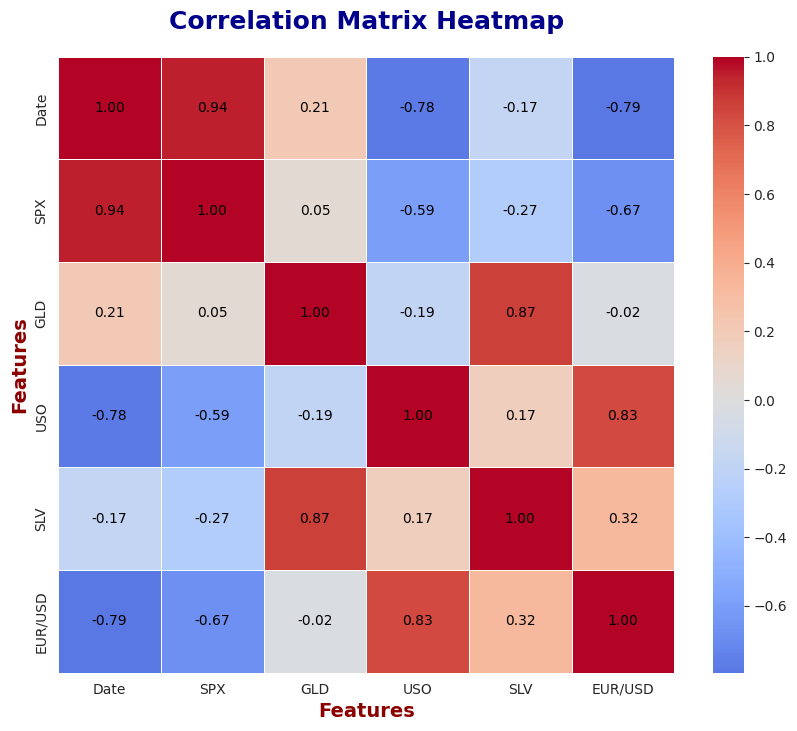

In [ ]:
correlation = dataset.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a custom colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Draw the heatmap with the custom colormap
sns.heatmap(correlation, cmap=cmap, center=0, annot=True, fmt=".2f",
            annot_kws={"size": 10, "color": "black"}, linewidths=.5, square=True)

# Add title and axis labels with custom font properties
plt.title('Correlation Matrix Heatmap', fontsize=18, fontweight='bold', color='darkblue', pad=20)
plt.xlabel('Features', fontsize=14, fontweight='bold', color='darkred')
plt.ylabel('Features', fontsize=14, fontweight='bold', color='darkred')

# Show plot
plt.show()

In [ ]:
# drop SlV column
dataset.drop("SLV", axis=1,
			inplace=True)

In [ ]:
# Resetting the index of the dataset to the 'Date' column
dataset.set_index("Date", inplace=True)

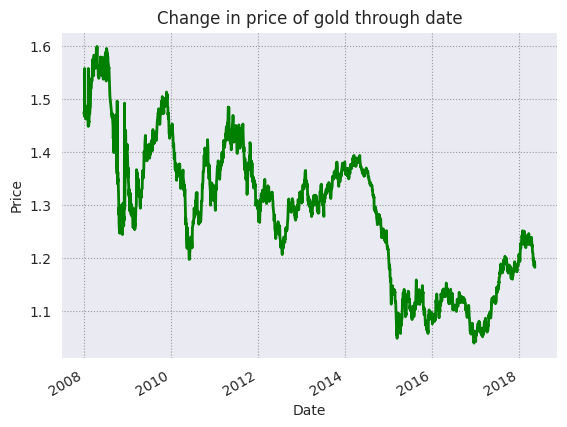

In [ ]:
# plot price of gold for each increasing day
dataset["EUR/USD"].plot(color='green', linestyle='-', linewidth=2)
plt.title("Change in price of gold through date")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)  # Adding gridlines
plt.show()


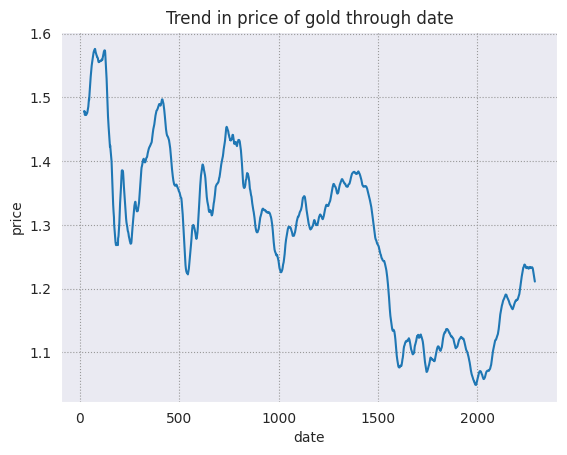

In [ ]:
# apply rolling mean with window size of 3
dataset["price_trend"] = dataset["EUR/USD"]\
	.rolling(window=20).mean()

# reset the index to date column
dataset.reset_index("Date", inplace=True)

# since we have used rolling method
# for 20 rows first 2 rows will be NAN
dataset["price_trend"].loc[20:].plot()

# set title of the chart
plt.title("Trend in price of gold through date")

# set x_label of the plot
plt.xlabel("date")
plt.ylabel("price")
plt.show()


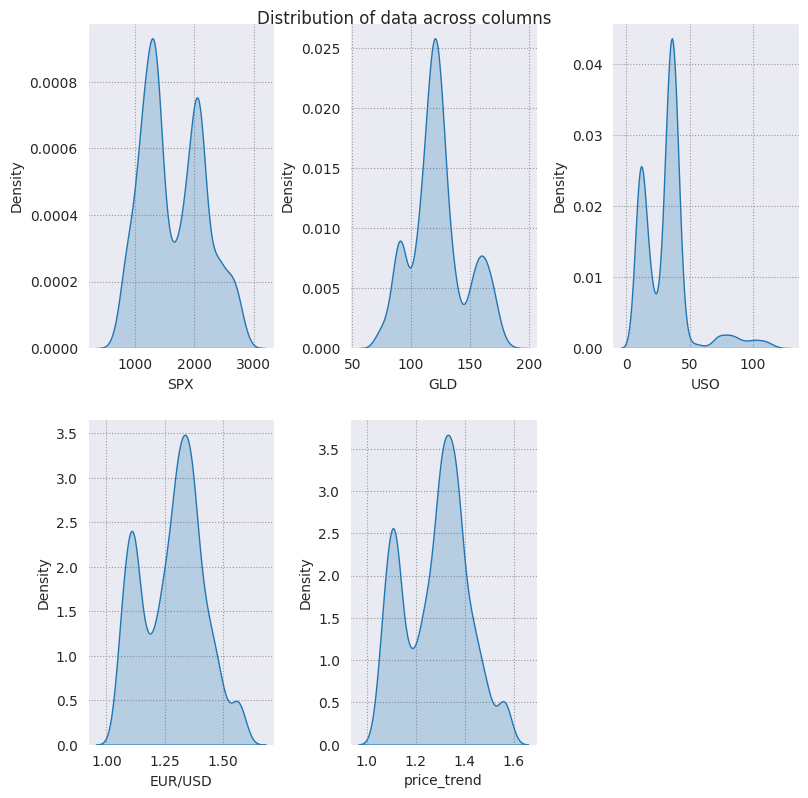

In [ ]:
fig = plt.figure(figsize=(8, 8))

# Title of the graph
fig.suptitle('Distribution of data across columns')

# Get column names except "Date"
temp = dataset.drop("Date", axis=1).columns.tolist()

# Plot KDE plots for each column
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(data=dataset[item], fill=True)
    plt.xlabel(item)
    plt.ylabel('Density')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [ ]:
def outlier_removal(column):
	# Capping the outlier rows with Percentiles
	upper_limit = column.quantile(.95)
	# set upper limit to 95percentile
	lower_limit = column.quantile(.05)
	# set lower limit to 5 percentile
	column.loc[(column > upper_limit)] = upper_limit
	column.loc[(column < lower_limit)] = lower_limit
	return column



In [ ]:
# Normalize outliers in columns except Date

dataset[['SPX', 'GLD', 'USO', 'EUR/USD']] = \
	dataset[['SPX', 'GLD', 'USO', 'EUR/USD']].apply(outlier_removal)


In [ ]:
# select the features and target variable
X = dataset.drop(['Date', 'EUR/USD'], axis=1)

y = dataset['EUR/USD']
# dividing dataset in to train test
x_train, x_test,\
	y_train, y_test = train_test_split(X, y,
									test_size=0.2)


In [ ]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler on the training dataset
scaler.fit(x_train)

# Transform the training dataset
# using the StandardScaler
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
# Create a PolynomialFeatures object of degree 2
poly = PolynomialFeatures(degree=2)

# Create a Lasso object
lasso = Lasso()

# Define a dictionary of parameter values to search over
param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2,
                                1e-1, 1, 5, 10,
                                20, 30, 40]}

# Create a pipeline that first applies polynomial features and then applies Lasso regression
pipeline = make_pipeline(poly, lasso)

# Create a GridSearchCV object with the pipeline and parameter grid
lasso_grid_search = GridSearchCV(pipeline,
                                param_grid,
                                scoring='r2', cv=3)

# Fit the GridSearchCV object to the training data
lasso_grid_search.fit(x_train_scaled, y_train)

# Predict the target variable using the fitted model and the test data
y_pred = lasso_grid_search.predict(x_train_scaled)

# Compute the R-squared of the fitted model on the train data
r2 = r2_score(y_train, y_pred)

# Print the R-squared
print("R-squared: ", r2)

# Print the best parameter values and score
print('Best parameter values: ',
      lasso_grid_search.best_params_)
print('Best score: ',
      lasso_grid_search.best_score_)

R-squared:  0.8387982103677535
Best parameter values:  {'lasso__alpha': 0.0001}
Best score:  0.8355941438243204